<a href="https://colab.research.google.com/github/Keerthik008/TaxiServices/blob/main/nyc_demand_forecast_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective

Divide the map into regions of equal size (geohashes) and then predict taxi demand in each geohash based on time-based features like hour of day, day of week, month, and geo-coordinates.

In [1]:
!pip install python-Geohash

<h2>1. Import Libraries</h2>

In [2]:
!pip install python-geohash pandas catboost matplotlib scikit-learn

In [3]:
from google.colab import drive
drive.mount('/content/train')

Drive already mounted at /content/train; to attempt to forcibly remount, call drive.mount("/content/train", force_remount=True).


In [4]:
!pip install geohash

In [5]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import Geohash
import matplotlib
import numpy as np
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [6]:
!pip install scikit-learn==1.4
from sklearn.metrics import root_mean_squared_error

<h2>2. Loading the Data</h2><br>
<p>Load the data using the Pandas `read_csv` function:</p>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train = pd.read_csv('/content/drive/MyDrive/train/train.csv')

<h2>3. Initial Data Exploration</h2><br>

<h3>3.1 File structure</h3><br>
<p>Let's start off by exploring the files we just imported, using Pandas `head` and `describe` functions:</p>

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [10]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


<p>Note the use of `pd.set_option('display.float_format', lambda x: '%.3f' % x)` to set the display options. More on that [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.set_option.html "Pandas set_option").</p>

<p>You can also use `train.tail()` to display the last 5 entries in the two files. From the output we can get an idea of the way the data is structured. Of course, this isn't strictly necessary, since it is possible to get the same view by navigating to the *Input Files* at the top and clicking on any one of the CSV files used in this analysis.</p>
<br>
<h3>3.2 Data Summary</h3><br>
<p>Getting a statistical summary of the data is also quite easy. This is where the `describe` function comes in:</p>

In [11]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


<p>Let's take a moment to think about what we're seeing here. What stands out? Initially nothing, until we get to the `trip_duration`. A minimum of 1 second, and a maximum of 3 526 282 seconds (roughly 980 hours). No way someone took a trip that long, the bill would be astronomical. And a 1 second trip won't get you anywhere. So clearly there are some outliers we need to deal with.</p>

<p>As a final way of looking at the data initially, consider the use of Pandas' `info` function. The advantage of using this particular function is getting an almost combined view of `describe` and `head`/`tail`, together with `shape` (which describes the number of rows and columns in the particular file). More on the use and output of `info` [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html "Pandas info").</p>

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


<p>So now that we have an idea of what the data looks like and the type of variables we're working with, what's next? This is where the fun really begins.</p>

<h2>4. Data Preparation</h2>

<h3>4.1 Trip Duration Clean-up</h3><br>

There many outliers in the trip_duration column. Let's visualize all the trips with duration less than 6000 seconds.

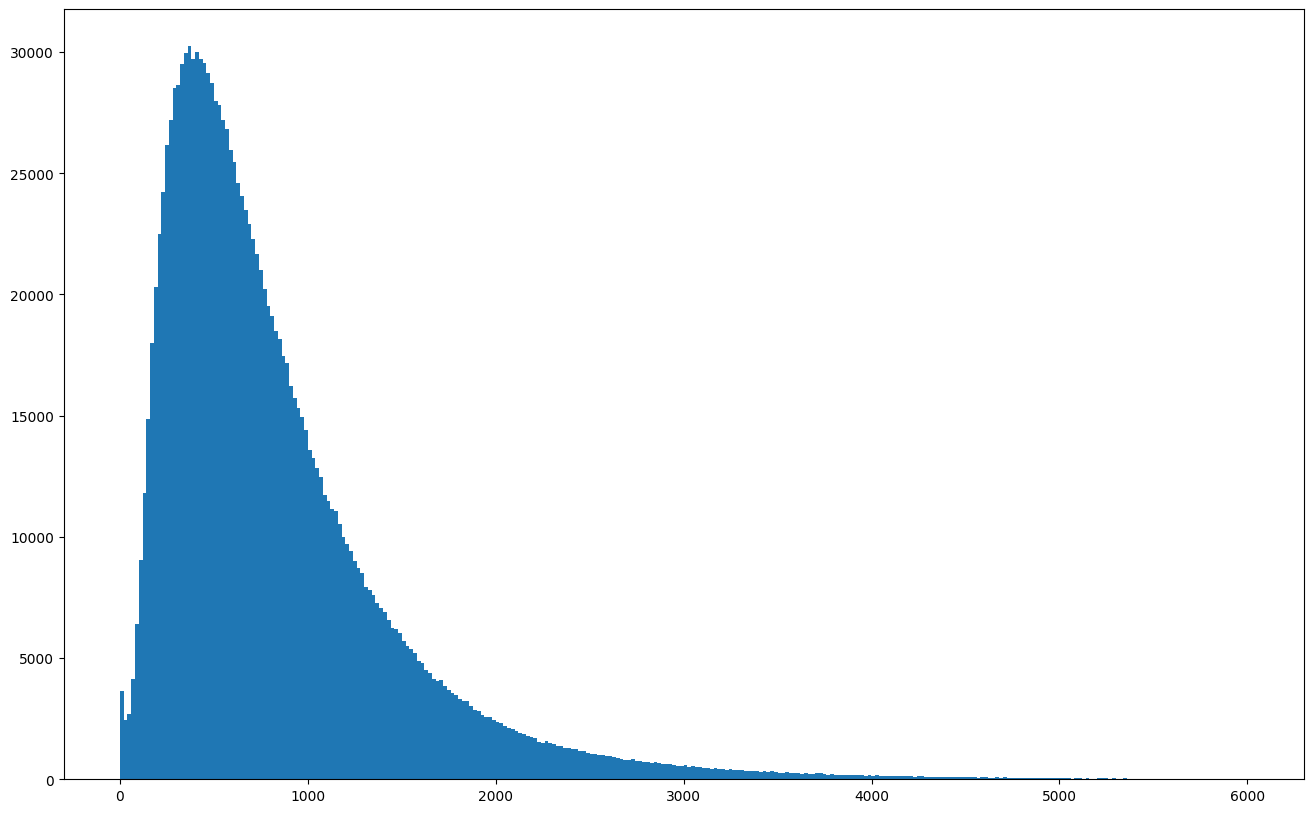

In [13]:
# plot trip duration for trips <= 6000 seconds
plt.hist(train[train['trip_duration'] <= 6000]['trip_duration'], bins = 300)
plt.show()

Let's remove the trips that are less than 2 minutes in duration or greater than 6000 seconds.

In [14]:
train = train[(train['trip_duration'] >= 120) & (train['trip_duration'] <= 6000)]

<h3>4.2 Latitude and Longitude Clean-up</h3><br>
<p>Looking into it, the borders of NY City, in coordinates comes out to be:</p>

city_long_border = (-74.03, -73.75)<br>
city_lat_border = (40.63, 40.85)
<br>

<p>Comparing this to our `train.describe()` output we see that there are some coordinate points (pick ups) that fall outside these borders. So let's limit our area of investigation to within the NY City borders.</p>

In [15]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]

<h3>4.3 Date Clean-up</h3><br>
<p>As a final step in preparing our data we need to change the formatting of the date variables (`pickup_datetime` and `dropoff_datetime`).</p>

In [16]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

In [17]:
# extract month from datetime
train['month'] = train['pickup_datetime'].dt.month_name()

In [18]:
# extract pickup hour
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_hour'].head()

0    17
1     0
2    11
3    19
4    13
Name: pickup_hour, dtype: int64

In [19]:
# extract pickup day of week
train['pickup_day'] = train['pickup_datetime'].dt.day_name()
train['pickup_day'].head()

0       Monday
1       Sunday
2      Tuesday
3    Wednesday
4     Saturday
Name: pickup_day, dtype: object

<h3>4.4 Visualize coordinates</h3>

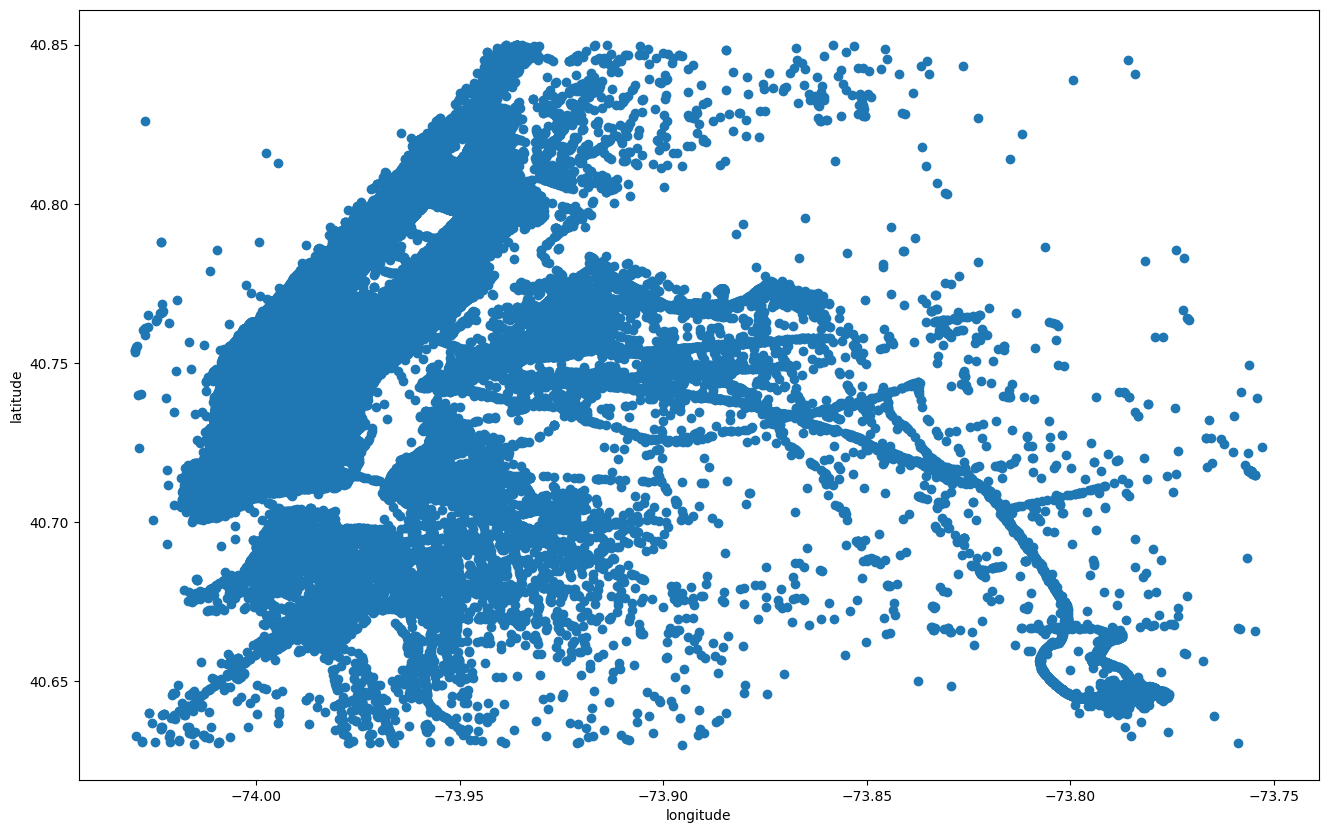

In [20]:
plt.scatter(train['pickup_longitude'], train['pickup_latitude'])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

<h3>4.5 Geo Hashing</h3>

In [21]:
# get geohash for ecah coordinate
geo_hash = [Geohash.encode(i, j, 5) for i,j in zip(train['pickup_latitude'], train['pickup_longitude'])]

In [22]:
# count of distinct geohashes
len(np.unique(geo_hash))

41

In [23]:
# add geohashes as a new column
train['geo_hash'] = geo_hash

In [24]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,pickup_hour,pickup_day,geo_hash
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,March,17,Monday,dr5ru
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,June,0,Sunday,dr5ru
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,January,11,Tuesday,dr5ru
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,April,19,Wednesday,dr5re
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,March,13,Saturday,dr72h


In [25]:
# aggregate data on 'geo_hash', 'month', 'pickup_day', and 'pickup_hour'
demand_df = train.groupby(['geo_hash', 'month', 'pickup_day', 'pickup_hour']).agg({'id': 'count'}).rename(columns={'id': 'demand'})

In [26]:
demand_df = demand_df.reset_index()

In [27]:
demand_df.shape

(17069, 5)

In [28]:
# create a new feature for weekend (1) and weekdays (0)
demand_df['weekend'] = np.where((demand_df['pickup_day'] == "Sunday") | (demand_df['pickup_day'] == "Saturday"),
                                1, 0)

In [29]:
# create a new feature for time of day
def time_of_day(hour):
    if hour >= 23 or hour < 4:
        return 'late_night'
    elif hour >= 4 and hour < 6:
        return 'early_morning'
    elif hour >= 6 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 16:
        return 'noon'
    elif hour >= 16 and hour < 21:
        return 'evening'
    else:
        return 'night'

demand_df['time_of_day'] = demand_df['pickup_hour'].apply(time_of_day)

In [30]:
demand_df['time_of_day'].value_counts()

morning          4311
evening          3607
late_night       3541
noon             2822
night            1486
early_morning    1302
Name: time_of_day, dtype: int64

Let's extract latitude and longitude coordinates for each geohash so that we can use them as features to train the machine learning model.

In [31]:
# extract coordinates of each geohash
demand_df['latitude'] = [Geohash.decode(i)[0] for i in demand_df['geo_hash']]
demand_df['longitude'] = [Geohash.decode(i)[1] for i in demand_df['geo_hash']]

In [32]:
demand_df.head()

,geo_hash,month,pickup_day,pickup_hour,demand,weekend,time_of_day,latitude,longitude
0,dr5r5,April,Friday,4,1,0,early_morning,40.627441,-74.025879
1,dr5r5,April,Friday,11,1,0,morning,40.627441,-74.025879
2,dr5r5,April,Friday,19,1,0,evening,40.627441,-74.025879
3,dr5r5,April,Friday,21,1,0,night,40.627441,-74.025879
4,dr5r5,April,Friday,22,1,0,night,40.627441,-74.025879


In [85]:
import seaborn

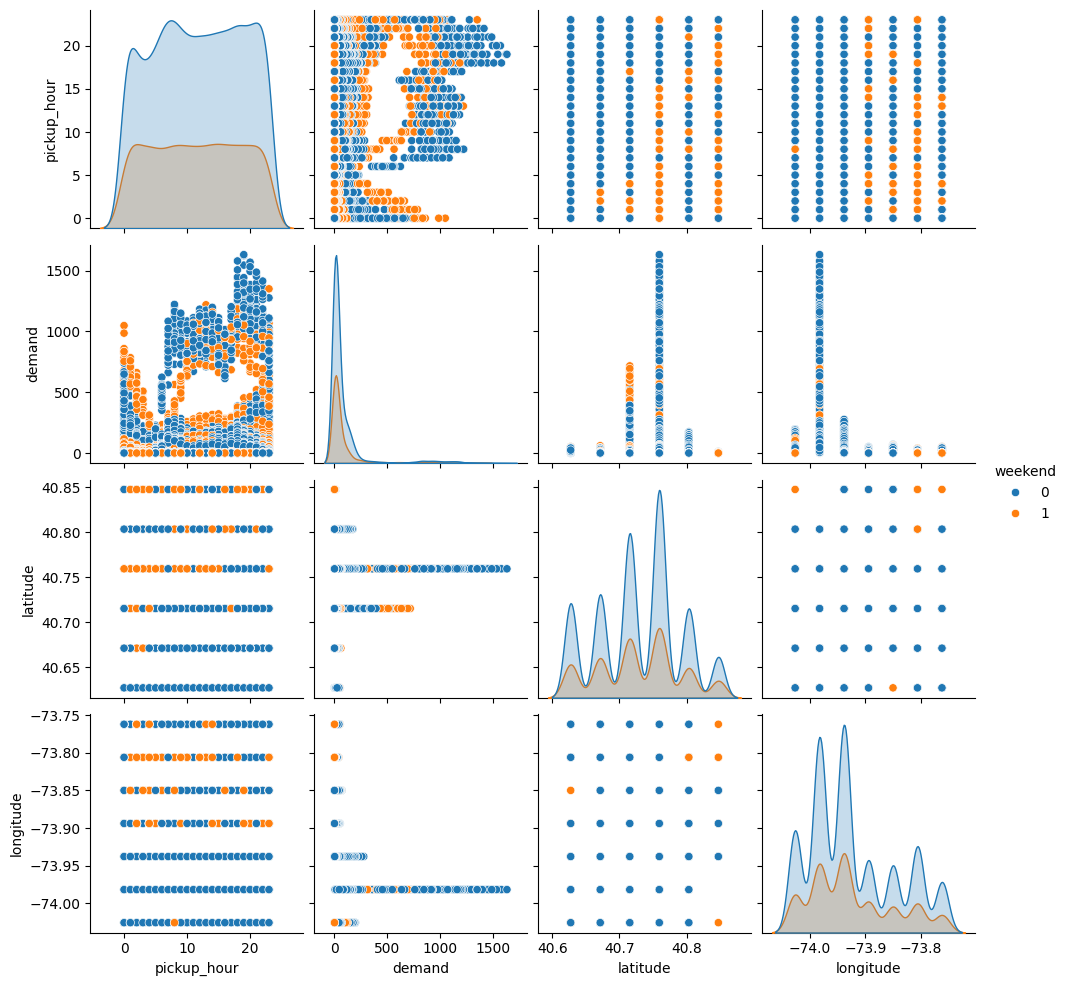

In [86]:
seaborn.pairplot(demand_df, hue ='weekend')

In [33]:
demand_df['month'].value_counts()

May         2906
March       2879
June        2839
April       2838
January     2817
February    2790
Name: month, dtype: int64

<h3>4.6 Visualize taxi demand for a sample</h3>

In [34]:
# specify month, pickup day, pickup hour
month_input = "May"
day_input = "Friday"
hour_input = 18

# extract sample data from aggregated demand data
sample_df = demand_df[(demand_df['month'] == month_input) &
                      (demand_df['pickup_day'] == day_input) &
                      (demand_df['pickup_hour'] == hour_input)]

In [35]:
# extract sample data from trip data
sample_train_df = train[(train['month'] == month_input) &
                        (train['pickup_day'] == day_input) &
                        (train['pickup_hour'] == hour_input)]

In [36]:
# get demand data for each trip in the sample data
sample_train_df = pd.merge(sample_train_df, sample_df[['geo_hash', 'demand']],
                           on= "geo_hash", how="left")

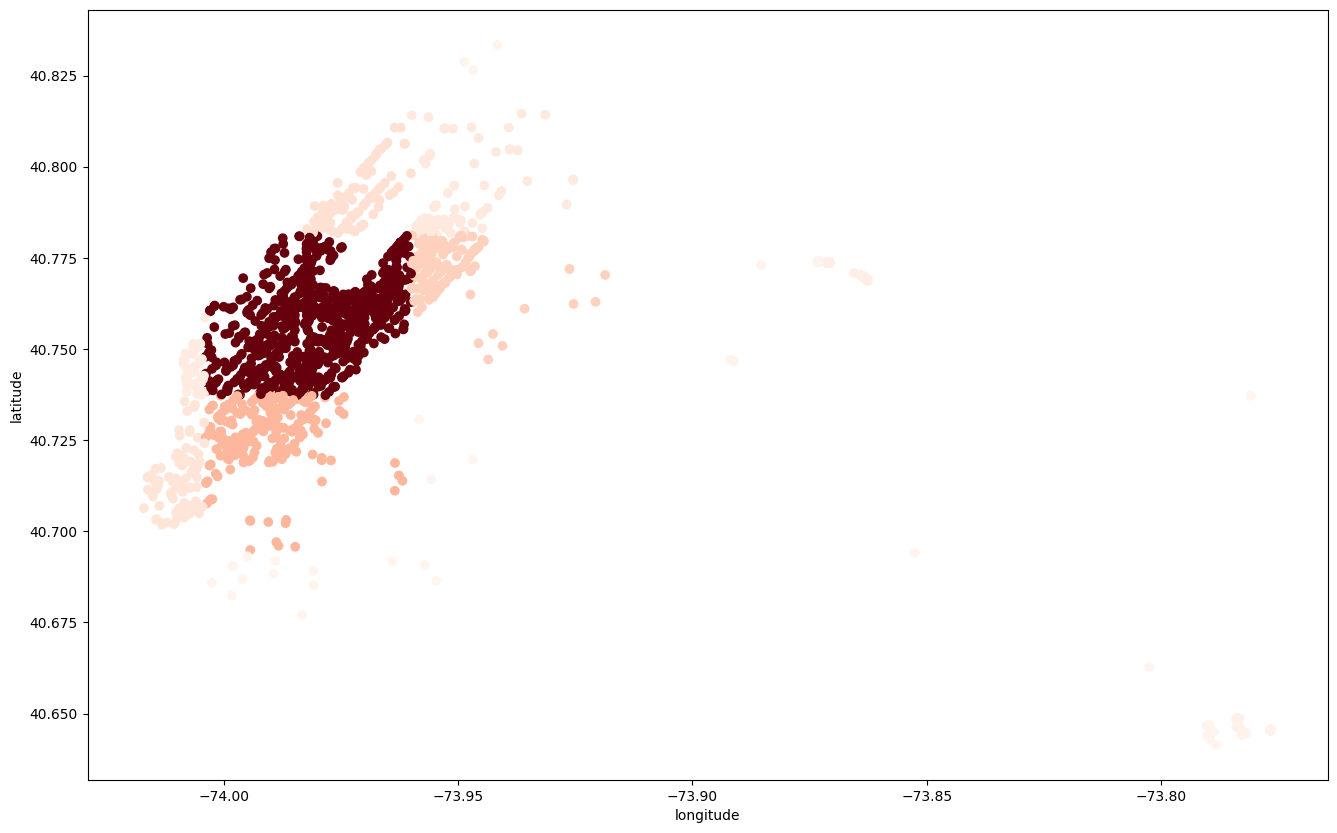

In [37]:
# visualize demand data for the sample data
plt.scatter(sample_train_df['pickup_longitude'], sample_train_df['pickup_latitude'],
            c=sample_train_df['demand'], cmap = "Reds")
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

<h3>4.6 Train-test split</h3>

In [38]:
X = demand_df[['month', 'pickup_day', 'pickup_hour', 'weekend', 'time_of_day', 'latitude', 'longitude']]

# 5. Regression Model

In [48]:
X_copy = X

5.1 Linear Regression

In [49]:
import time

In [50]:
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder

In [52]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_copy)

OneHotEncoder(handle_unknown='ignore')

In [53]:
X_copy = enc.transform(X_copy)

In [54]:
# split the data into train and test set
xtrain, xtest, ytrain, ytest = train_test_split(X_copy, demand_df['demand'],
                                                test_size=0.33,
                                                random_state=42)

In [55]:
start_time = time.time()

In [56]:
model1 = linear_model.LinearRegression()

In [57]:
# Fit model
model1.fit(xtrain, ytrain)

# Get demand predictions for each geohash
preds = model1.predict(xtest)

In [58]:
# find mean absolute percentage error
mape_lr = mean_absolute_percentage_error(ytest, preds)
mape_lr

21.184556224248336

In [59]:
rmse_lr = root_mean_squared_error(ytest, preds)
rmse_lr

145.2618544745545

In [60]:
end_time = time.time()
dif_time_lr = end_time-start_time
print(dif_time_lr)

0.09225988388061523


In [61]:
from sklearn.tree import DecisionTreeRegressor

In [62]:
import time

In [63]:
start_time = time.time()

In [64]:
model2 = DecisionTreeRegressor()

In [65]:
# Fit model
model2.fit(xtrain, ytrain)

# Get demand predictions for each geohash
preds = model2.predict(xtest)

In [66]:
rmse_dt = root_mean_squared_error(ytest, preds)
rmse_dt

32.6721743172058

In [67]:
# find mean absolute percentage error
mape_dt = mean_absolute_percentage_error(ytest, preds)
mape_dt

0.3767263318521038

In [68]:
end_time = time.time()
dif_time_dt = end_time-start_time
print(dif_time_dt)

0.4349641799926758


5.2 CatBoost Regression Model

We will use CatBoost algorithm to build the regression model because it can handle categorical features without any data preprocesing. Before that, it is necessary to specify the indices of the categorical features in the training data.

In [69]:
# split the data into train and test set
xtrain, xtest, ytrain, ytest = train_test_split(X, demand_df['demand'],
                                                test_size=0.33,
                                                random_state=42)

In [70]:
# categorical features
cat_features = [0,1,4]

In [71]:
start_time = time.time()

In [72]:
# define model
model = CatBoostRegressor(iterations=500,
                          verbose= False,
                          learning_rate=0.005,
                          depth=8)

In [73]:
# Fit model
model.fit(xtrain, ytrain, cat_features)

# Get demand predictions for each geohash
preds = model.predict(xtest)

Now let's evaluate the model on the test set. We will use mean absolute percentage error (MAPE) as the evaluation metric.

In [74]:
rmse_cat = root_mean_squared_error(ytest, preds)
rmse_cat

51.215643227382806

In [75]:
# find mean absolute percentage error
mape_cat = mean_absolute_percentage_error(ytest, preds)
mape_cat

3.5634549123199646

The predictions vary 3.56% from the actual values in the test set.

In [76]:
end_time = time.time()
dif_time_cat = end_time -start_time
print(dif_time_cat)

8.775156736373901


In [77]:
import pandas as pd

In [81]:
time_diff = pd.DataFrame({
             'Alogorithm':['Linear Regression', 'CatBoost Regression', 'Decision Trees'],
             'Model_Fit_Time':[dif_time_lr, dif_time_cat, dif_time_dt],
             'MAPE':[mape_lr, mape_cat, mape_dt],
             'RMSE':[rmse_lr, rmse_cat, rmse_dt]
                          })

In [82]:
time_diff

,Alogorithm,Model_Fit_Time,MAPE,RMSE
0,Linear Regression,0.092260,21.184556,145.261854
1,CatBoost Regression,8.775157,3.563455,51.215643
2,Decision Trees,0.434964,0.376726,32.672174


from matplotlib import pyplot as plt
time_diff['Model_Fit_Time'].plot(kind='hist', bins=20, title='Model_Fit_Time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
time_diff['MAPE'].plot(kind='hist', bins=20, title='MAPE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
time_diff['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
time_diff.groupby('Alogorithm').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
time_diff.plot(kind='scatter', x='Model_Fit_Time', y='MAPE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
time_diff.plot(kind='scatter', x='MAPE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Model_Fit_Time']
  ys = series['MAPE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = time_diff.sort_values('Model_Fit_Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Alogorithm')):
  _plot_series(series, series_name, i)
  fig.legend(title='Alogorithm', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Model_Fit_Time')
_ = plt.ylabel('MAPE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Model_Fit_Time']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = time_diff.sort_values('Model_Fit_Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Alogorithm')):
  _plot_series(series, series_name, i)
  fig.legend(title='Alogorithm', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Model_Fit_Time')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Model_Fit_Time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Model_Fit_Time'}, axis=1)
              .sort_values('Model_Fit_Time', ascending=True))
  xs = counted['Model_Fit_Time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = time_diff.sort_values('Model_Fit_Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Alogorithm')):
  _plot_series(series, series_name, i)
  fig.legend(title='Alogorithm', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Model_Fit_Time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
time_diff['Model_Fit_Time'].plot(kind='line', figsize=(8, 4), title='Model_Fit_Time')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
time_diff['MAPE'].plot(kind='line', figsize=(8, 4), title='MAPE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
time_diff['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(time_diff['Alogorithm'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(time_diff, x='Model_Fit_Time', y='Alogorithm', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(time_diff['Alogorithm'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(time_diff, x='MAPE', y='Alogorithm', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(time_diff['Alogorithm'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(time_diff, x='RMSE', y='Alogorithm', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

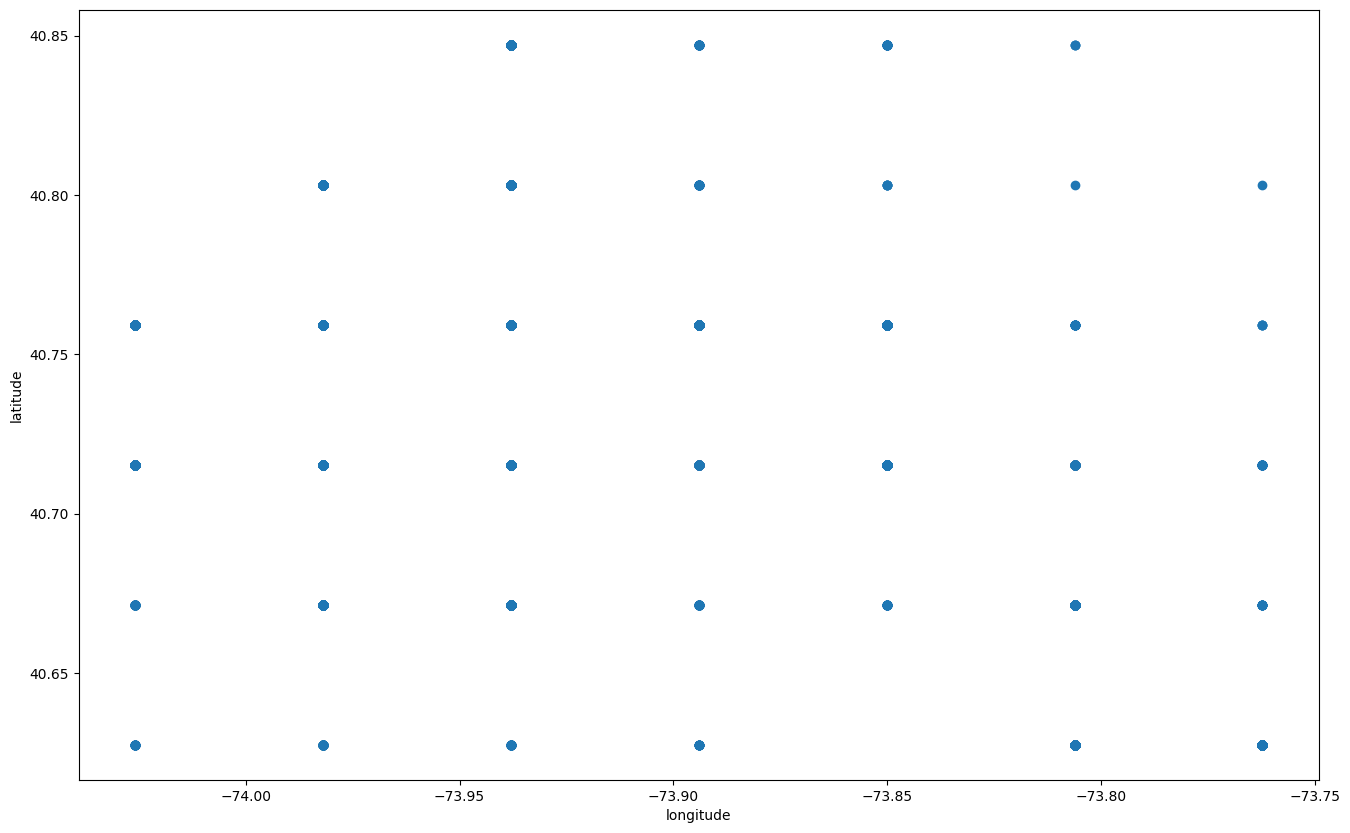

In [80]:
plt.scatter(xtest['longitude'], xtest['latitude'])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()